# Compare Autoencoders Models

In [0]:
%%capture
#Install skorch package 
!pip install skorch

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Vizualization 
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

#Torch
import torch
from torch import nn, optim
import torch.nn.functional as F

#Torch wrapper
import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LRScheduler

#Utilities
import os
import pickle

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Download and Prase Data

In [0]:
%%capture
#Get data, small file so no if
if not os.path.isfile('all_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-ET9vXPKudU92XuWeR0wIL67byS2llq-' -O all_scaled0_1.csv
if not os.path.isfile('no_rfe_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-6Z60VHL0gk3pd8hKF7-btW_cM_DWTB6' -O no_rfe_scaled0_1.csv
if not os.path.isfile('models.7z'): 
    !wget 'https://drive.google.com/uc?export=download&id=1RPhLO70ip98tvbb4YImXPtEn1Sgz9svy' -O models.7z
    !7z x models.7z
if not os.path.isfile('simple_ae.pt'): 
    !wget 'https://drive.google.com/uc?export=download&id=1xkr3hEUj5ijvfyGajFxwDp9tSxb1CKV5' -O simple_ae.pt
if not os.path.isfile('vae.pt'): 
    !wget 'https://drive.google.com/uc?export=download&id=1R7c5CQww6iX43qWLhsaakccTLzcSD1B2' -O vae.pt

In [0]:
data_file = 'no_rfe_scaled0_1.csv'
folder = 'models/no_rfe/'

In [0]:
data = pd.read_csv(data_file,index_col=0)
labels = data['label']
run = data['run']
chunkID = data['chunkID']
period = data['period']
data = data.drop(['label','chunkID','run','period'], axis = 1)

no_samples, no_features = data.shape

print(no_samples, no_features)
print(labels.value_counts())

data.head()

3429 133
0.0    3262
1.0     167
Name: label, dtype: int64


,bz,meanTPCnclF,meanTPCChi2,rmsTPCChi2,slopeATPCnclF,slopeCTPCnclF,slopeATPCnclFErr,slopeCTPCnclFErr,meanTPCncl,rmsTPCncl,slopeCTPCncl,slopeCTPCnclErr,hasRawQA,rawSignalCounter,slopedZA,offsetdZC,slopedZC,offsetdZAErr,slopedZAErr,offsetdZAchi2,slopedZAchi2,offsetdZCPos,offsetdZAchi2Pos,slopedZAchi2Pos,offsetdZCchi2Pos,slopedZCchi2Pos,slopedZANeg,offsetdZCNeg,slopedZCNeg,offsetdZAchi2Neg,slopedZAchi2Neg,offsetdZCchi2Neg,slopedZCchi2Neg,offsetdRC,offsetdRAchi2,slopedRAchi2,offsetdRCchi2,slopedRCchi2,dcarAP0,dcarCP0,...,dcar_negA_chi2,dcar_negA_0_Err,dcar_negA_1_Err,dcar_negA_2_Err,dcaz_negA_0,dcaz_negA_1,dcaz_negA_0_Err,dcaz_negA_1_Err,dcaz_negA_2_Err,dcaz_negC_chi2,dcaz_negC_0_Err,dcaz_negC_1_Err,dcaz_negC_2_Err,dcar_negC_chi2,dcar_negC_0_Err,dcar_negC_1_Err,dcar_negC_2_Err,iroc_A_side,oroc_A_side,iroc_C_side,oroc_C_side,tpcItsMatchA,tpcItsMatchC,phiPullHighPt,ptPull,ptPullHighPt,yPullHighPt,zPull,zPullHighPt,lambdaPull,meanPTRelativeA,medianPTRelativeA,rmsPTRelativeA,medianPTRelativeC,meanHVandPTGainCorrIROC,medianHVandPTGainCorrIROC,meanHVandPTGainCorrOROC,medianHVandPTGainCorrOROC,meanVDriftCorr,rmsVDriftCorr
0,0.0,0.650378,0.586648,0.299807,0.567304,0.506033,0.029799,0.506033,0.661859,0.130696,0.432987,0.432987,1.0,0.630747,0.505639,0.456515,0.479150,0.029047,0.025431,0.066360,0.066360,0.422997,0.018955,0.018955,0.103951,0.103951,0.347511,0.486962,0.366647,0.135214,0.135214,0.154272,0.154272,0.104897,0.041065,0.041065,0.165264,0.165264,0.023750,0.012700,...,0.040081,0.089056,0.082068,0.091172,0.387952,0.529658,0.075152,0.073086,0.076870,0.049049,0.064750,0.062988,0.066403,0.096599,0.092639,0.089595,0.096029,1.0,1.0,1.0,1.0,0.532074,0.586826,0.558088,0.489128,0.478282,0.397318,0.303648,0.494765,0.564013,0.644374,0.643025,0.030060,0.644593,0.644385,0.643058,0.731516,0.730402,0.062052,0.033067
1,0.0,0.652363,0.579001,0.299619,0.553643,0.490807,0.028887,0.490807,0.662852,0.129801,0.431335,0.431335,1.0,0.630747,0.471739,0.656468,0.622429,0.028192,0.024807,0.098105,0.098105,0.626295,0.078152,0.078152,0.195836,0.195836,0.318030,0.662324,0.531044,0.126243,0.126243,0.205944,0.205944,0.184002,0.120756,0.120756,0.277622,0.277622,0.023131,0.013681,...,0.029575,0.088029,0.080961,0.090309,0.368447,0.537606,0.074312,0.072295,0.075983,0.053690,0.062965,0.061329,0.064488,0.080482,0.090666,0.087815,0.093847,1.0,1.0,1.0,1.0,0.529813,0.583827,0.618659,0.506106,0.508984,0.428699,0.344592,0.458420,0.559882,0.645829,0.644559,0.044541,0.646086,0.645843,0.644604,0.732617,0.731569,0.061865,0.008953
2,0.0,0.656779,0.582115,0.302841,0.576802,0.486826,0.028507,0.486826,0.664891,0.128520,0.414198,0.414198,1.0,0.630747,0.424595,0.774050,0.716557,0.027634,0.024176,0.102944,0.102944,0.748653,0.144460,0.144460,0.224404,0.224404,0.301996,0.760046,0.627993,0.067836,0.067836,0.248870,0.248870,0.229955,0.088526,0.088526,0.349164,0.349164,0.022454,0.013235,...,0.040652,0.088169,0.080976,0.090568,0.377793,0.560263,0.073681,0.071540,0.075483,0.070414,0.062983,0.061441,0.064412,0.067023,0.090231,0.087507,0.093285,1.0,1.0,1.0,1.0,0.534614,0.584458,0.572836,0.508496,0.493338,0.420849,0.341413,0.461882,0.561373,0.645117,0.644090,0.046651,0.645604,0.645142,0.644119,0.732088,0.731203,0.061668,0.027615
3,0.0,0.650338,0.590880,0.307098,0.573718,0.465535,0.029239,0.465535,0.657125,0.127972,0.413237,0.413237,1.0,0.630747,0.453121,0.865839,0.786867,0.029305,0.025690,0.074307,0.074307,0.849890,0.084640,0.084640,0.224069,0.224069,0.307199,0.833085,0.699755,0.059567,0.059567,0.296804,0.296804,0.268384,0.103972,0.103972,0.427887,0.427887,0.023129,0.016565,...,0.024053,0.088482,0.081358,0.090786,0.376294,0.584689,0.074933,0.072717,0.076810,0.095369,0.064623,0.062784,0.066359,0.065335,0.091349,0.088426,0.094600,1.0,1.0,1.0,1.0,0.520301,0.572863,0.602295,0.511802,0.537189,0.439337,0.365844,0.496001,0.529956,0.639891,0.637870,0.174869,0.639382,0.639929,0.637938,0.728152,0.726535,0.061461,0.007084
4,0.0,0.654262,0.591539,0.319091,0.584242,0.494138,0.028849,0.494138,0.663947,0.132655,

## Compare Models

In [0]:
# check if CUDA is available
gpu = torch.cuda.is_available()
if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Classic Outliers

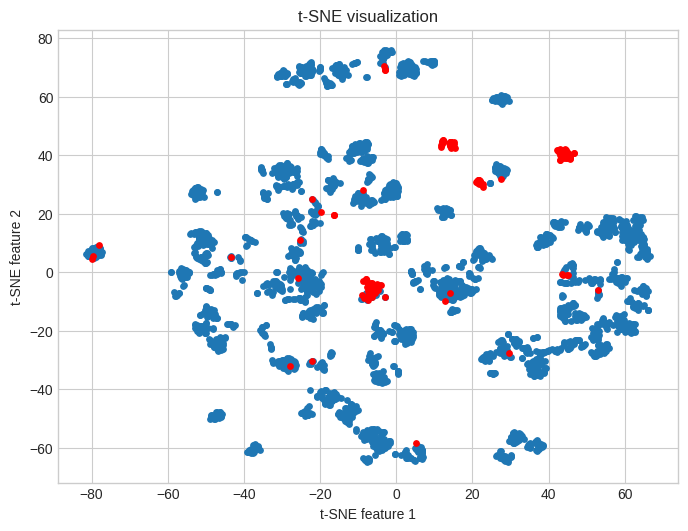

In [0]:
X_embedded = pickle.load(open(folder+'t_sne.pkl','rb'))

corr = X_embedded[labels == 0]
wrong = X_embedded[labels == 1]

fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(corr[:,0], corr[:,1], s=15)
ax.scatter(wrong[:,0], wrong[:,1], color='red', s=15)

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');

In [0]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

#Define functions for calculation and visualization of ROC and Prec and Recall 
def rocVizualisation(y_test, pred_scores):
    fpr, tpr, thresholds = roc_curve(y_test, pred_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC curve')
    plt.plot(fpr, tpr, color='b', lw=2, label='AUC = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

def prec_recallVizualisation(y_test, pred_scores):
    precision, recall, thresholds = precision_recall_curve(y_test, pred_scores, pos_label=1)
    prec_recall_auc = auc(recall, precision)

    plt.figure(figsize = (8,6))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([0, 1],[0.5, 0.5], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Precision-Recall curve')
    plt.plot(recall, precision, color='b', lw=2, label='AUC area = %0.2f)' % prec_recall_auc)
    plt.legend(loc="lower right")
    plt.show()

### Simple 

In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(self.fc3(x)) #Only droput on last layer no ReLu
        return x

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

In [0]:
#Parameters setting
dropout = 0.3
#Encoding
latent_ratio = [0.5, 0.3, 0.1] #Must be 3 elements

In [0]:
net = NeuralNetRegressor(
    SimpleAutoEncoder,
    module__no_features = no_features,
    module__lat_r = latent_ratio,
    module__dropout = dropout,
    device='cuda' if gpu else 'cpu',
)

Load and evaluate

In [0]:
#Load model with lowest validation accuracy
net.initialize()
net.load_params('simple_ae.pt')

X = torch.FloatTensor(data.to_numpy())
X_rec = net.forward(X)

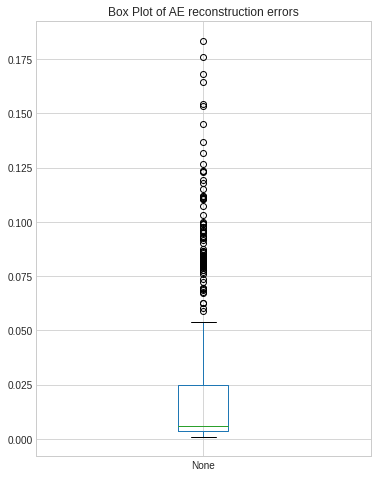

In [0]:
loss_func = nn.MSELoss()
errors = np.array([loss_func(X_el, X_rec_el).item() for (X_el, X_rec_el) in zip(X, X_rec)])
pd.Series(errors).plot.box(figsize = (6,8), title='Box Plot of AE reconstruction errors')

In [0]:
#Specify how maany % of samples shpuld be defined as outliers 
cutoff = 0.04

threshold = np.sort(errors)[round((1-cutoff) * errors.shape[0])]
print(threshold)
print(np.count_nonzero(errors > threshold))

0.047879647463560104
136


In [0]:
#Number of matching outliers with warnings
n_1 = np.where(labels == 1, 1, 0)
n_2 = np.where(errors > threshold, 1, 0)
n = np.where((n_1 == 1) & (n_2 == 1), 1, 0)
sum(n)

106

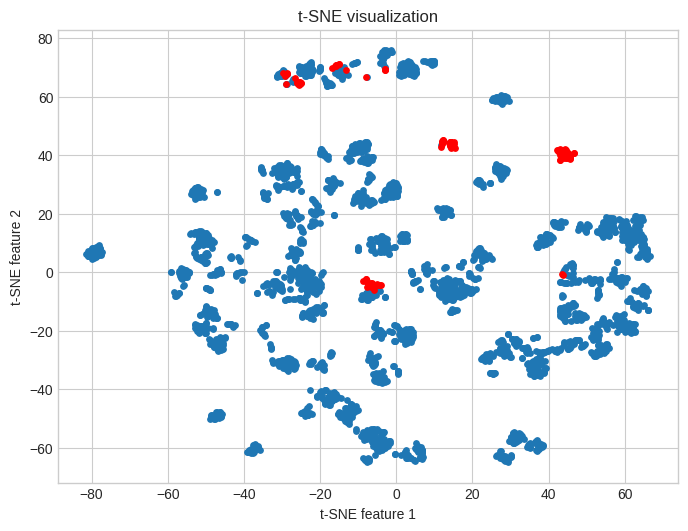

In [0]:
X_embedded = pickle.load(open(folder+'t_sne.pkl','rb'))

corr = X_embedded[np.where(errors < threshold)]
wrong = X_embedded[np.where(errors > threshold)]

fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(corr[:,0], corr[:,1], s=15)
ax.scatter(wrong[:,0], wrong[:,1], color='red', s=15)

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');

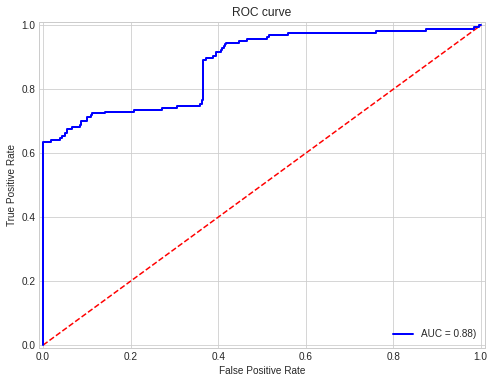

In [0]:
rocVizualisation(labels.to_numpy(), errors)

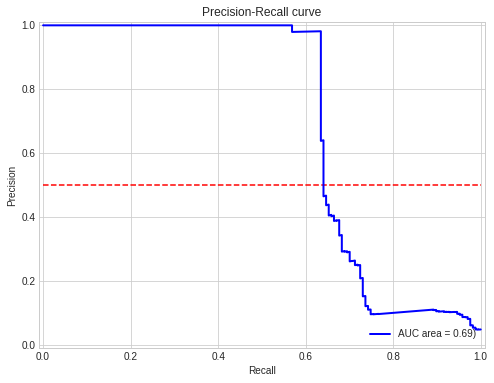

In [0]:
prec_recallVizualisation(labels.to_numpy(), errors)

### VAE

In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3_1 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.fc3_2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))

        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        # What is returned is mu and logvar, mean and var that will be used to cacl std
        return self.dropout(self.fc3_1(x)), self.dropout(self.fc3_2(x))

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class VAE(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std    

    def forward(self, X):
        mu, logvar = self.encoder(X)
        z = self.reparameterize(mu, logvar)

        return self.decoder(z), mu, logvar

In [0]:
#Instaciate model and set training parameters
model = VAE(no_features, latent_ratio, dropout)

Load and Evaluate

In [0]:
# Load best model
model.load_state_dict(torch.load('vae.pt'))

X_rec_avg = []
for i in range(100):
    X_rec = model.forward(X)[0] #Get just decoded side
    X_rec_avg.append(X_rec)
X_rec_avg = torch.mean(torch.stack(X_rec_avg), dim=0)

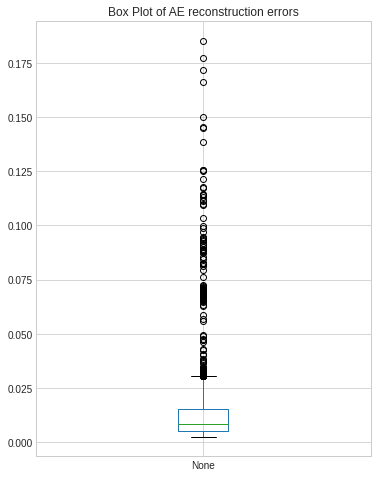

In [0]:
loss_func = nn.MSELoss()
errors = np.array([loss_func(X_el, X_rec_el).item() for (X_el, X_rec_el) in zip(X, X_rec_avg)])
pd.Series(errors).plot.box(figsize = (6,8), title='Box Plot of AE reconstruction errors')

In [0]:
#Specify how maany % of samples shpuld be defined as outliers 
cutoff = 0.04

threshold = np.sort(errors)[round((1-cutoff) * errors.shape[0])]
print(threshold)
print(np.count_nonzero(errors > threshold))

0.03358616307377815
136


In [0]:
#Number of matching outliers with warnings
n_1 = np.where(labels == 1, 1, 0)
n_2 = np.where(errors > threshold, 1, 0)
n = np.where((n_1 == 1) & (n_2 == 1), 1, 0)
sum(n)

116

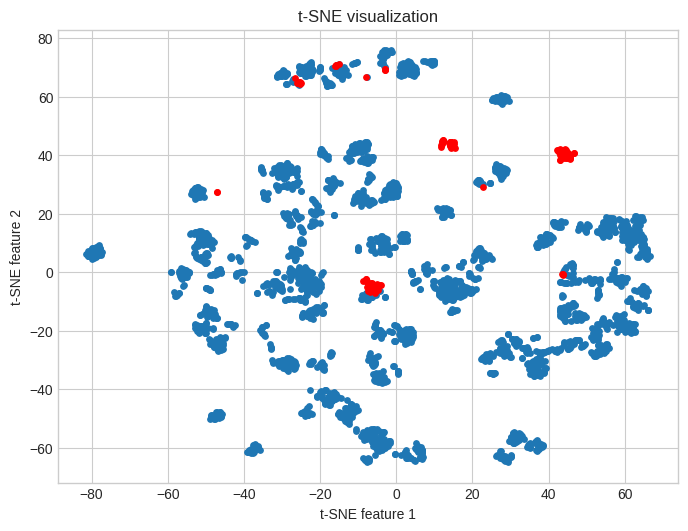

In [0]:
X_embedded = pickle.load(open(folder+'t_sne.pkl','rb'))

corr = X_embedded[np.where(errors < threshold)]
wrong = X_embedded[np.where(errors > threshold)]

fig = plt.figure(figsize = (8,6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(corr[:,0], corr[:,1], s=15)
ax.scatter(wrong[:,0], wrong[:,1], color='red', s=15)

ax.set_title('t-SNE visualization')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2');

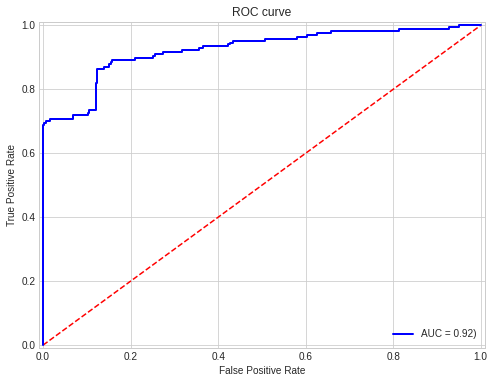

In [0]:
rocVizualisation(labels.to_numpy(), errors)

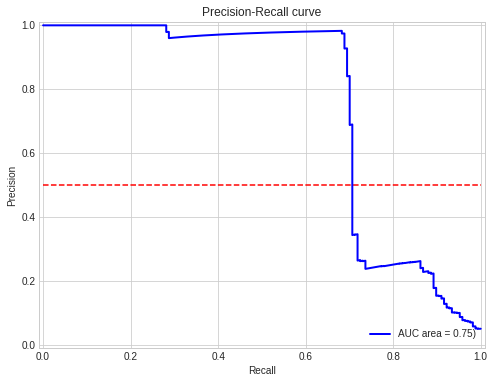

In [0]:
prec_recallVizualisation(labels.to_numpy(), errors)